In [1]:
import pandas as pd
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split, cross_validate
from surprise import KNNBasic
from surprise import accuracy
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
food_data = pd.read_csv('data/food.csv')
ratings_data = pd.read_csv('data/ratings.csv')

In [2]:
ratings_data

,User_ID,Food_ID,Rating
0,1.0,88.0,4.0
1,1.0,46.0,3.0
2,1.0,24.0,5.0
3,1.0,25.0,4.0
4,2.0,49.0,1.0
...,...,...,...
507,99.0,22.0,1.0
508,100.0,24.0,10.0
509,100.0,233.0,10.0
510,100.0,29.0,7.0


In [3]:
# Merge data
merged_data = pd.merge(ratings_data, food_data, on='Food_ID')

# Define a Reader
reader = Reader(rating_scale=(1, 10))

# Create Surprise Dataset
data = Dataset.load_from_df(merged_data[['User_ID', 'Food_ID', 'Rating']], reader)

# Train-test split
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

In [4]:
merged_data.head()

,User_ID,Food_ID,Rating,Name,C_Type,Veg_Non,Describe
0,1.0,88.0,4.0,peri peri chicken satay,Snack,non-veg,"boneless skinless chicken thigh (trimmed), sal..."
1,1.0,46.0,3.0,steam bunny chicken bao,Japanese,non-veg,"buns, all purpose white flour, dry yeast, suga..."
2,3.0,46.0,2.0,steam bunny chicken bao,Japanese,non-veg,"buns, all purpose white flour, dry yeast, suga..."
3,20.0,46.0,6.0,steam bunny chicken bao,Japanese,non-veg,"buns, all purpose white flour, dry yeast, suga..."
4,69.0,46.0,9.0,steam bunny chicken bao,Japanese,non-veg,"buns, all purpose white flour, dry yeast, suga..."


/tmp/ipykernel_66581/2002446591.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')


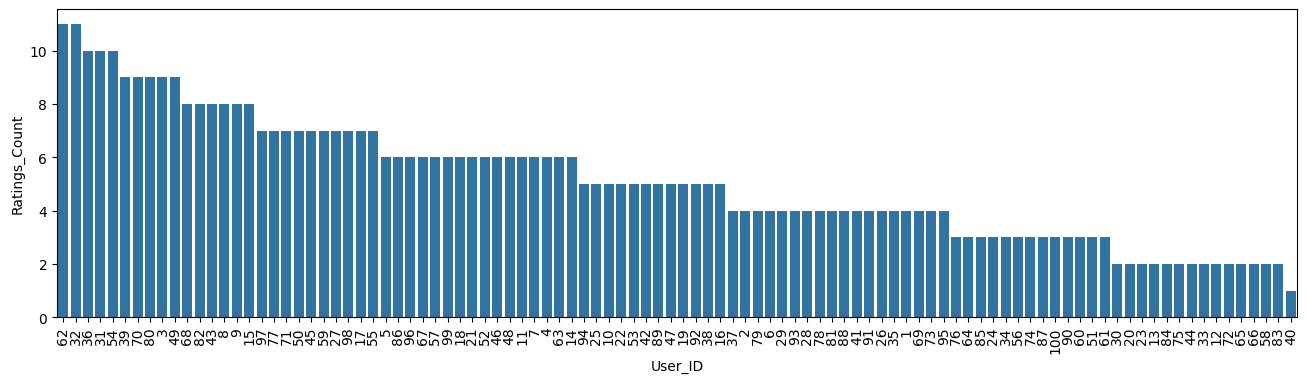

In [5]:
user_ratings_count = merged_data['User_ID'].value_counts().reset_index()
user_ratings_count.columns = ['User_ID', 'Ratings_Count']
user_ratings_count = user_ratings_count.sort_values('Ratings_Count', ascending=False)
user_ratings_count['User_ID'] = user_ratings_count['User_ID'].astype(int).astype(str)

plt.figure(figsize=(16, 4))
ax = sns.barplot(x='User_ID', y='Ratings_Count', data=user_ratings_count)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
plt.show()

Un maximum de 11 ratings pour 309 recettes et seulement 100 utilisateurs, c'est pas beaucoup

In [6]:
# Define the similarity options (cosine similarity in this case)
sim_options = {
    'name': 'cosine',
    'user_based': True
}

# Build the collaborative filtering model
model = KNNBasic(sim_options=sim_options)


In [7]:
# Train the model
model.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


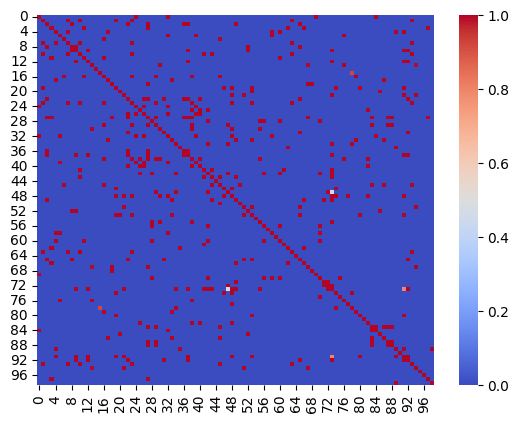

In [8]:
# Print the similarity matrix as a heatmap
sns.heatmap(model.sim, cmap='coolwarm')
plt.show()

In [20]:
def user_based_recommendation(user_ID):
    # Get the list of all food IDs
    food_ids = merged_data['Food_ID'].unique()

    # Get the list of food IDs rated by the user
    food_ids_user_rated = merged_data[merged_data['User_ID'] == user_ID]['Food_ID'].values

    # Get the list of food IDs not rated by the user
    food_ids_user_not_rated = [food_id for food_id in food_ids if food_id not in food_ids_user_rated]

    # Create a list of tuples in the format (food_id, user_id, rating) for all food IDs not rated by the user
    food_ids_user_not_rated = [(food_id, user_ID, 0) for food_id in food_ids_user_not_rated]

    # Predict ratings for all food IDs not rated by the user
    predictions = model.test(food_ids_user_not_rated)

    # Get top 10 predictions
    recommendations = []
    for food_id, user_id, rating, _, _ in predictions:
        recommendations.append((food_id, rating))

    recommendations.sort(key=lambda x: x[1], reverse=True)
    recommendations = recommendations[:5]

    # Get food names
    food_names = []
    for recommendation in recommendations:
        food_names.append(food_data[food_data['Food_ID'] == recommendation[0]]['Name'].values[0])

    return food_names

In [22]:
# Get top 10 recommendations for test user
test_user = 48

print("Ratings given by user {}:".format(test_user))
user_ratings = merged_data[merged_data['User_ID'] == test_user]
# print(user_ratings[['Name', 'Rating']].sort_values('Rating', ascending=False))

# Get top 10 recommendations for test user
print("\nTop 10 recommendations for user {}:".format(test_user))
user_based_recommendation(test_user)

Ratings given by user 48:
                                                  Name  Rating
367                                 chicken dong style     8.0
368                               zucchini methi pulao     8.0
193                             chocolate nero cookies     5.0
340  garlic and pinenut soup with burnt butter essence     3.0
207                               cream of almond soup     3.0
187                               dahi lasooni chicken     1.0

Top 10 recommendations for user 48:


['peri peri chicken satay',
 'steam bunny chicken bao',
 'green lentil dessert fudge',
 'cashew nut cookies',
 'christmas tree pizza']

In [11]:
# Make predictions on the test set
predictions = model.test(testset)

In [12]:
# Evaluate the model
accuracy.rmse(predictions)

RMSE: 3.0914


3.0914219641571106

## Fine-tuning

In [13]:
from surprise.model_selection import GridSearchCV

param_grid = {
  'n_factors': [20, 50, 100, 200, 400, 800, 1000],
  'n_epochs': [5, 10, 20, 50, 100, 200]
}


gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=10)
gs.fit(data)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [14]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

3.0766354534442155
{'n_factors': 20, 'n_epochs': 5}


In [15]:
# best hyperparameters
best_factor = gs.best_params['rmse']['n_factors']
best_epoch = gs.best_params['rmse']['n_epochs']

# We'll use the famous SVD algorithm.
model_ft = KNNBasic(n_factors=best_factor, n_epochs=best_epoch)

# Train the algorithm on the trainset
model_ft.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [16]:
cv = cross_validate(model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    3.0922  2.8042  2.8677  3.2364  2.9269  2.9855  0.1578  
MAE (testset)     2.6232  2.4463  2.4054  2.7569  2.4674  2.5398  0.1312  
Fit time          0.00    0.00    0.00    0.00    0.00    0.00    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    


We can see that we obtain somewhat better results.

In [19]:
user_ID = 48



# Get the list of all food IDs
food_ids = merged_data['Food_ID'].unique()

# Get the list of food IDs rated by the user
food_ids_user_rated = merged_data[merged_data['User_ID'] == user_ID]['Food_ID'].values

# Get the list of food IDs not rated by the user
food_ids_user_not_rated = [food_id for food_id in food_ids if food_id not in food_ids_user_rated]

# Create a list of tuples in the format (food_id, user_id, rating) for all food IDs not rated by the user
food_ids_user_not_rated = [(food_id, user_ID, 0) for food_id in food_ids_user_not_rated]

# Predict ratings for all food IDs not rated by the user
predictions = model.test(food_ids_user_not_rated)

# Get top 10 predictions
recommendations = []
for food_id, user_id, rating, _, _ in predictions:
    recommendations.append((food_id, rating))

recommendations.sort(key=lambda x: x[1], reverse=True)
recommendations = recommendations[:5]

# Get food names
food_names = []
for recommendation in recommendations:
    food_names.append(food_data[food_data['Food_ID'] == recommendation[0]]['Name'].values[0])

print(food_names)

['peri peri chicken satay', 'steam bunny chicken bao', 'green lentil dessert fudge', 'cashew nut cookies', 'christmas tree pizza']
